In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qo '/content/drive/MyDrive/Bitext_Sample_Customer_Service.zip' -d '/content/drive/MyDrive/customer_support/'

In [ ]:
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1

In [ ]:
# Библиотека матричного вычисления
import numpy as np
# Библиотека для работы с данными
import pandas as pd
# Библиотека для работы с регулярными выражениями
import re
# Библиотека для работы с фреймворком TensorFlow
import tensorflow as tf
# Библиотека AutoML autokeras
import autokeras as ak
# Библиотеки для построения графиков и их стилизации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Утилита для расщепления выборки
from sklearn.model_selection import train_test_split

# Необходимые метрики для построения Матрицы ошибок и отчета о классификации
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/customer_support/Bitext_Sample_Customer_Service/Bitext_Sample_Customer_Service_Training_Dataset.csv', sep=',', on_bad_lines='skip')

In [ ]:
# удаляем столбец tags и intent
df_train.drop(['intent', 'tags'], axis=1, inplace=True)
# Удаляем дубликаты
df_train.drop_duplicates(inplace = True)

df_train.head()

,utterance,category
0,would it be possible to cancel the order I made?,ORDER
1,cancelling order,ORDER
2,I need assistance canceling the last order I h...,ORDER
3,problem with canceling the order I made,ORDER
4,I don't know how to cancel the order I made,ORDER


In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.utils import resample
import string

# Предобработка данных
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    # Удаление знаков препинания
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление стоп-слов
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    return text

df_train['utterance'] = df_train['utterance'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df_train
                                                           .utterance),
                                                  np.array(df_train
                                                           .category),
                                                  test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_tmp,
                                                  y_tmp,
                                                  test_size=0.5)

In [ ]:
print('Форма входных данных: ', X_train.shape)
print('Форма выходных меток: ', y_train.shape)
print('Пример заголовка: ', X_train[0])

Форма входных данных:  (4577,)
Форма выходных меток:  (4577,)
Пример заголовка:  dont know check cancellation fees


In [ ]:
# Создание ансамбля моделей (3 наиболее подходящие к данным моделей)
clf = ak.TextClassifier(overwrite=True, max_trials=2, objective='val_accuracy')

# Обучаем 2 модели на 4-х эпохах, размер пакета подбирается автоматически
result_training = clf.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val))

Trial 2 Complete [00h 00m 29s]
val_accuracy: 0.9969419240951538

Best val_accuracy So Far: 0.9989806413650513
Total elapsed time: 00h 03m 17s
Epoch 1/4
144/144 [==============================] - 36s 244ms/step - loss: 1.4846 - accuracy: 0.5193 - val_loss: 0.1501 - val_accuracy: 0.9776
Epoch 2/4
144/144 [==============================] - 34s 240ms/step - loss: 0.0619 - accuracy: 0.9908 - val_loss: 0.0085 - val_accuracy: 0.9990
Epoch 3/4
144/144 [==============================] - 33s 226ms/step - loss: 0.0133 - accuracy: 0.9974 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 4/4
144/144 [==============================] - 36s 250ms/step - loss: 0.0046 - accuracy: 0.9993 - val_loss: 0.0042 - val_accuracy: 0.9990


In [ ]:
# Предсказание на лучшей модели
predicted_y = clf.predict(X_test)

# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))

31/31 [==============================] - 4s 98ms/step - loss: 0.0119 - accuracy: 0.9980
[0.011923341080546379, 0.9979612827301025]


In [ ]:
def plot_graphs(history, key):
    # Используем библиотеку seaborn для задания стиля и цветовой схемы графика
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')

    # Задаем размер полотна для рисования графика
    plt.figure(figsize=(12,6))

    # Отображаем график выбранного параметра
    plt.plot(history.history[key],   # данные для построения графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[2],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    # График для проверочной выборки
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[4],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    # подпись оси Х, размер шрифта - 12
    plt.xlabel("Эпоха", fontsize=12)
    # подпись оси Y, размер шрифта - 12
    plt.ylabel(key, fontsize=12)

    # подпись заголовка графика, размер шрифта - 14
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14)

    # отображение легенды, размер шрифта - 12
    plt.legend(fontsize=12)

    # задаем сетку на графике
    plt.grid(True)

    # отрисовываем полотно со всеми графиками
    plt.show()

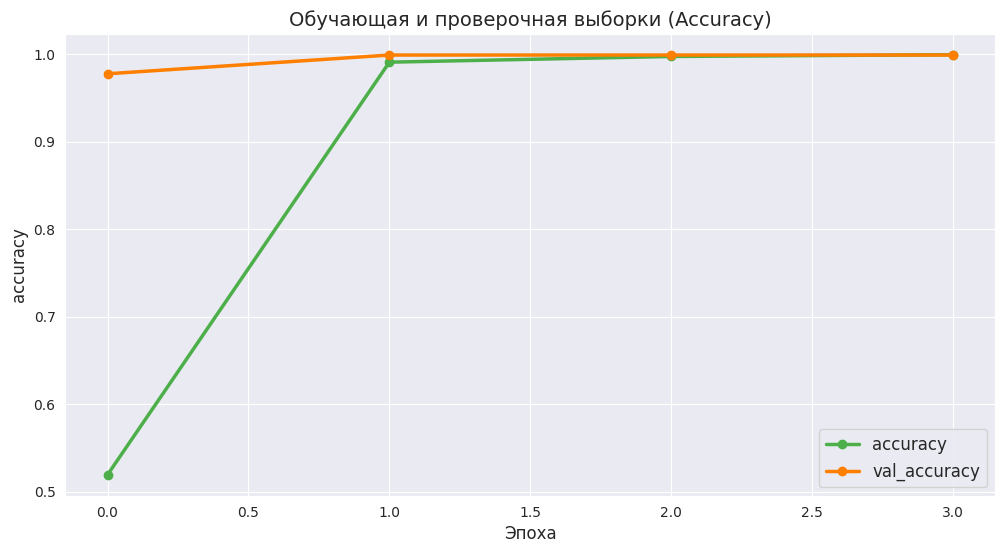

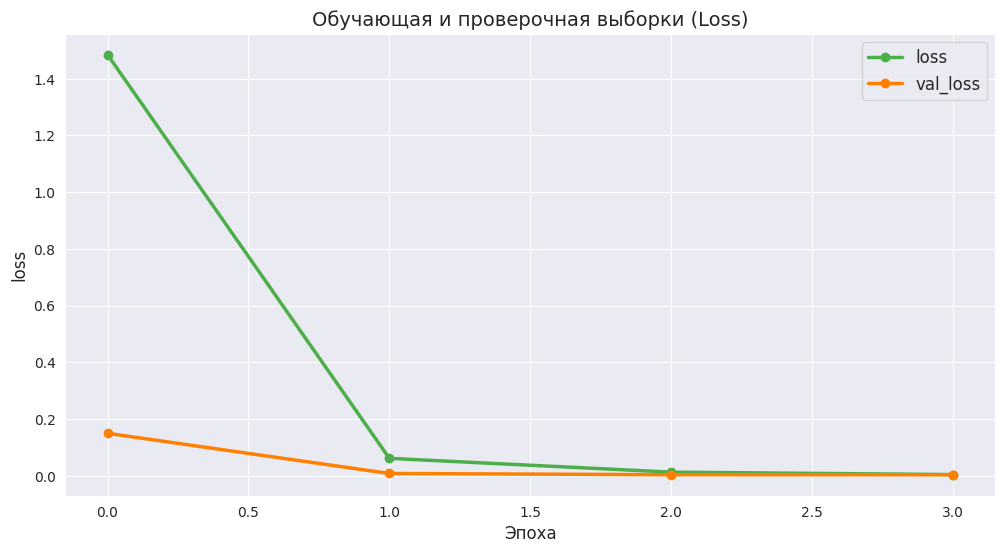

In [ ]:
# строим график точности
plot_graphs(result_training, "accuracy")

# строим график потерь
plot_graphs(result_training, "loss")

In [ ]:
print(classification_report(y_test, predicted_y))

                  precision    recall  f1-score   support

         ACCOUNT       1.00      1.00      1.00       213
CANCELLATION_FEE       1.00      1.00      1.00        29
         CONTACT       1.00      1.00      1.00        71
        DELIVERY       0.99      1.00      0.99        73
        FEEDBACK       1.00      1.00      1.00        84
         INVOICE       1.00      1.00      1.00        84
      NEWSLETTER       1.00      1.00      1.00        32
           ORDER       1.00      1.00      1.00       141
         PAYMENT       1.00      0.99      0.99        77
          REFUND       1.00      1.00      1.00        99
SHIPPING_ADDRESS       1.00      0.99      0.99        78

        accuracy                           1.00       981
       macro avg       1.00      1.00      1.00       981
    weighted avg       1.00      1.00      1.00       981



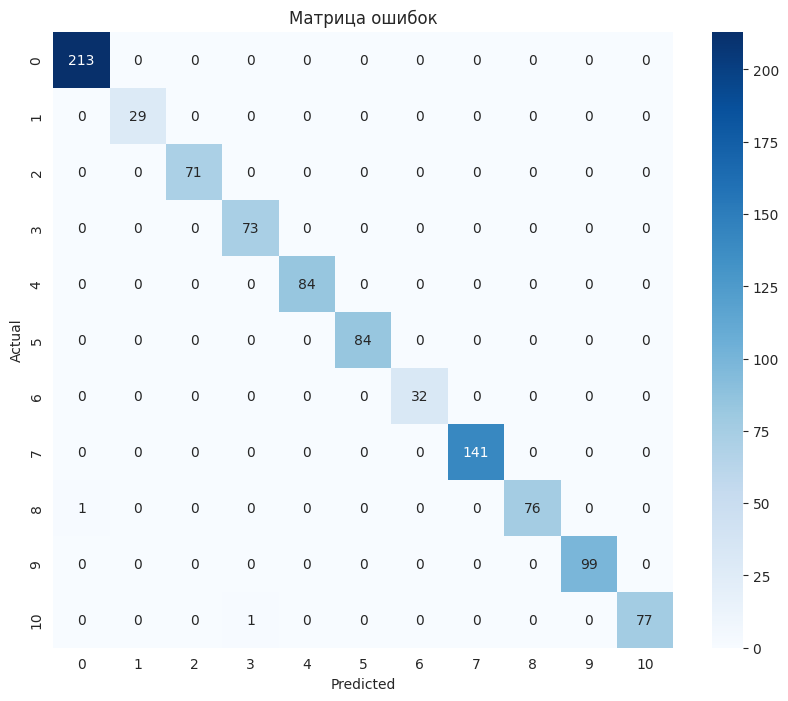

In [ ]:
conf_matrix = confusion_matrix(y_test, predicted_y)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок')
plt.show()